In [35]:
import warnings
warnings.filterwarnings("ignore")

Cargando dataset de entrenamiento

In [36]:
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import os

In [37]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    fp = open(path, 'rb')
    iterPDF = iter(PDFPage.get_pages(fp, set(), maxpages=0, password="",caching=True, check_extractable=True))
    next(iterPDF)

    for page in iterPDF:
        interpreter.process_page(page)
        text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [38]:
directorio_data_sets = r'D:\TP NLP\DataSet'
files = os.listdir(directorio_data_sets)
documentos = []

for f in files:
    if os.path.isfile(os.path.join(directorio_data_sets, f)) and f.endswith('.pdf'):
        documentos.append(convert_pdf_to_txt(os.path.join(directorio_data_sets, f)).replace('\n',''))

print("Documentos leidos: " + str(len(documentos)))

Documentos leidos: 110


Preprocesado del corpus

In [39]:
from nltk.corpus import stopwords
from nltk import re
from nltk import word_tokenize
import unicodedata

def preprocess_corpus(corpus):
    corpus = corpus.lower() 
    
    #eliminar signos de puntuacion
    words = [word for word in word_tokenize(corpus) if re.search("\w", word)]
    
    #eliminar stop words
    clean_corpus = ' '.join(filter(lambda x: x not in stopwords.words('spanish'), words))
    
    #eliminar numeros
    clean_corpus = ''.join([word for word in clean_corpus if not word.isdigit()])
    
    #eliminar caracteres unicode
    clean_corpus = unicodedata.normalize("NFKD", clean_corpus).encode("ascii","ignore").decode("ascii")
    clean_corpus = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', clean_corpus)
    
    #reemplazar espacios consecutivos por uno solo
    clean_corpus = re.compile(r"\s+").sub(" ", clean_corpus).strip()
    
    #eliminar algunas stop words particulares de los documentos
    special_stop_words = ['.-','...','k','que','cuestionario','preguntas','respuestas','responder','trabajo','practico','marketing','digital']
    clean_corpus  = ' '.join([word.lower() for word in re.split("\W+",clean_corpus) if word.lower() not in special_stop_words])
    
    #eliminar palabras de menos de 2 letras
    clean_corpus  = ' '.join([word.lower() for word in re.split("\W+",clean_corpus) if len(word)>2])
    
    return clean_corpus

In [40]:
clean_documents = []

for documento in documentos:
    clean_documents.append(preprocess_corpus(documento))

Fase de entrenamiento de Word2Vec

In [41]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [42]:
def train_and_plot_word2vec(dataset):
    # train model
    model = Word2Vec(dataset, min_count=1)

    # fit a 2d PCA model to the vectors
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)

    # create a scatter plot of the projection
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)

    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()
    
    return model

A modo de ejemplo, data set reducido

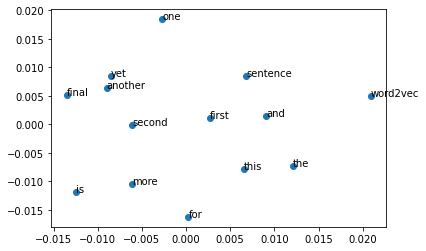

In [43]:
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
            ['this', 'is', 'the', 'second', 'sentence'],
            ['yet', 'another', 'sentence'],
            ['one', 'more', 'sentence'],
            ['and', 'the', 'final', 'sentence']]
model = train_and_plot_word2vec(sentences)


Sobre nuestro data set

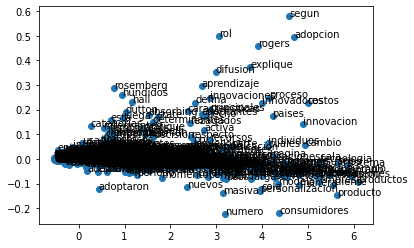

In [45]:
sentences = []
for sentence in clean_documents:
    sentences.append(sentence.split())

model = train_and_plot_word2vec(sentences)
model.save('modelo_entrenado_dataset_UTN.bin')

In [46]:
model.most_similar("numero")

[('maximo', 0.9992910623550415),
 ('consumidores', 0.9992771148681641),
 ('adoptaran', 0.9990105032920837),
 ('momento', 0.9988023042678833),
 ('estimar', 0.9987763166427612),
 ('periodo', 0.9987674951553345),
 ('nuevos', 0.9986516237258911),
 ('adquirir', 0.9985553026199341),
 ('consecuentemente', 0.9984613060951233),
 ('existentes', 0.9974950551986694)]